In [7]:
%matplotlib widget
from i_o import Paths, VolumeReader, AsyncH5Writer
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, showvid
import warpfield
from IPython.display import JSON
import pandas as pd
from widgets import get_mask_widget, ortho_views_widget, play_video_widget

In [86]:
pn_psfs = r"~/hpc-rw/lfm/psfs"
pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"

dataset_name = "20250701_1538_LB_ZF_v552_f5_40fps_1"
psf_name = "20250701_1216_PSF_LB_noap_1"
bg_name = "20250701_1651_LB_bg_40fps.npy"
# bg_name = "20250701_1649_LB_bg_80fps.npy"

import i_o
importlib.reload(i_o)
from i_o import Paths

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,
              )

In [55]:
reader = VolumeReader(paths.registered, "data", )
avg_vol = reader.get_next()[1]
for frame_n, vol in tqdm(reader):
    avg_vol+= (vol-avg_vol)/frame_n

  0%|          | 0/4020 [00:00<?, ?it/s]

In [56]:
reader = VolumeReader(paths.registered, "data", )
writer = AsyncH5Writer(paths.pn_outrec + "/noise_quantification.h5")
writer.create_dataset("mse_per_pixel", shape = reader.get_shape("data"))
writer.write_dataset("average_volume", avg_vol)
for frame_n, vol in tqdm(reader):
    mse = (vol-avg_vol)**2
    writer.write("mse_per_pixel", mse, frame_n)

  0%|          | 0/4020 [00:00<?, ?it/s]

In [57]:
reader = VolumeReader(paths.pn_outrec + "/noise_quantification.h5", "mse_per_pixel", )
avg_mse = reader.get_next()[1]
for frame_n, vol in tqdm(reader):
    avg_mse += (vol-avg_mse)/frame_n

  0%|          | 0/4020 [00:00<?, ?it/s]

In [58]:
writer.write_dataset("average_mse", avg_mse)

In [59]:
ortho_views_widget(avg_mse.transpose(0,2,1), vmax=10)

OrthoViewsWidget(coords=[72, 128, 400], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

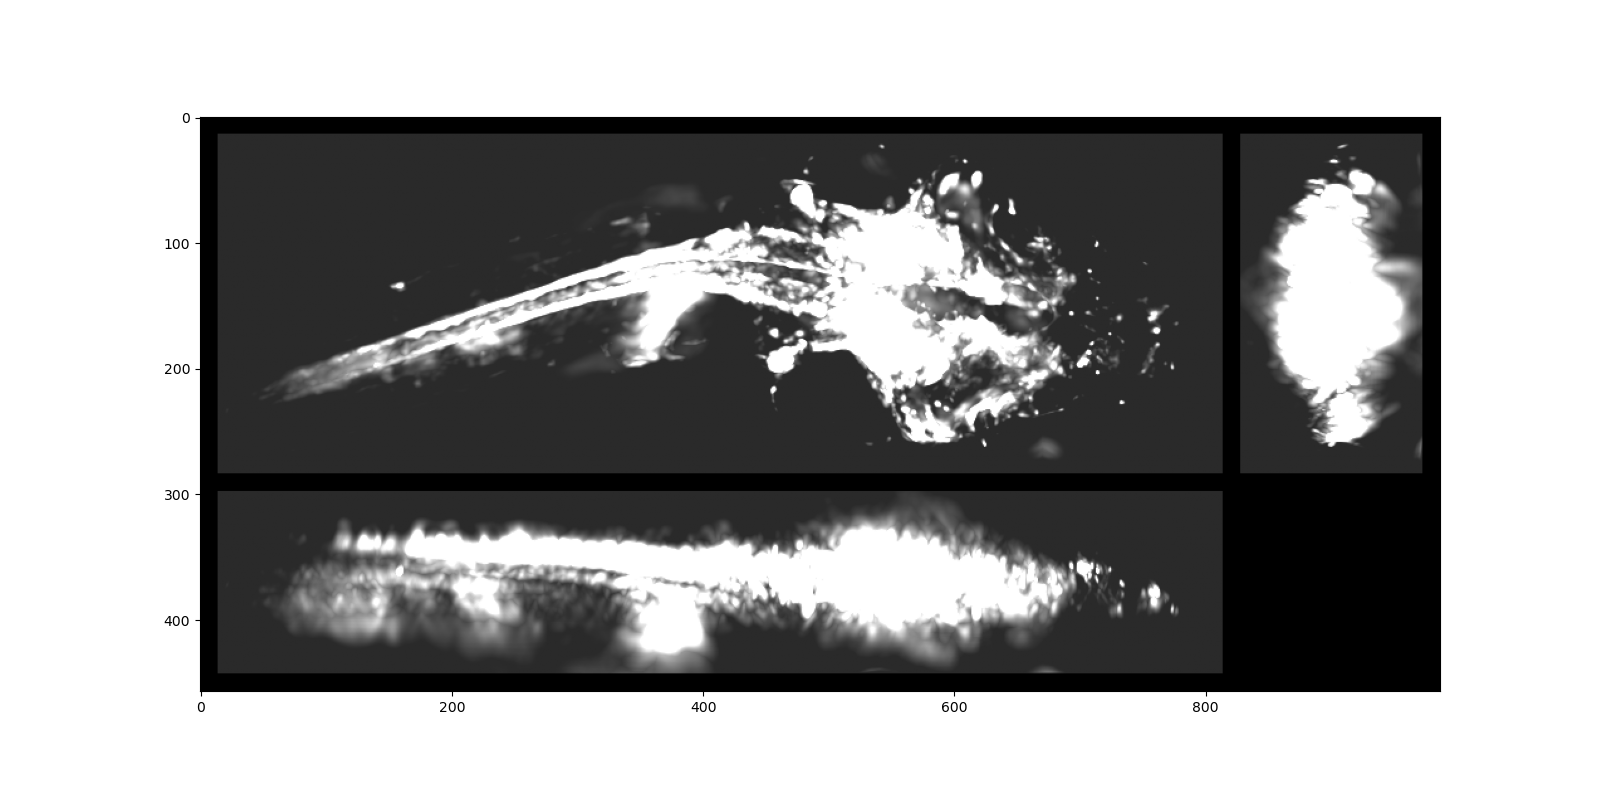

In [60]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.imshow(create_projection_image(avg_mse,vmax=1, transpose= True), cmap = "gray")


In [104]:
raw_reader = VolumeReader(paths.raw, "data")
reg_reader = VolumeReader(paths.registered, "data")
raw_brightness = []
reg_brightness = []
# variation = lambda x: cp.sqrt(cp.mean(x**2))/cp.mean(x)
for (frame_n, raw),(_, vol) in tqdm(zip(raw_reader, reg_reader)):
    raw_brightness.append(float(cp.asarray(raw).flatten().mean()))
    reg_brightness.append(float(cp.asarray(vol).flatten().mean()))



0it [00:00, ?it/s]

Text(0, 0.5, 'Raw brightness')

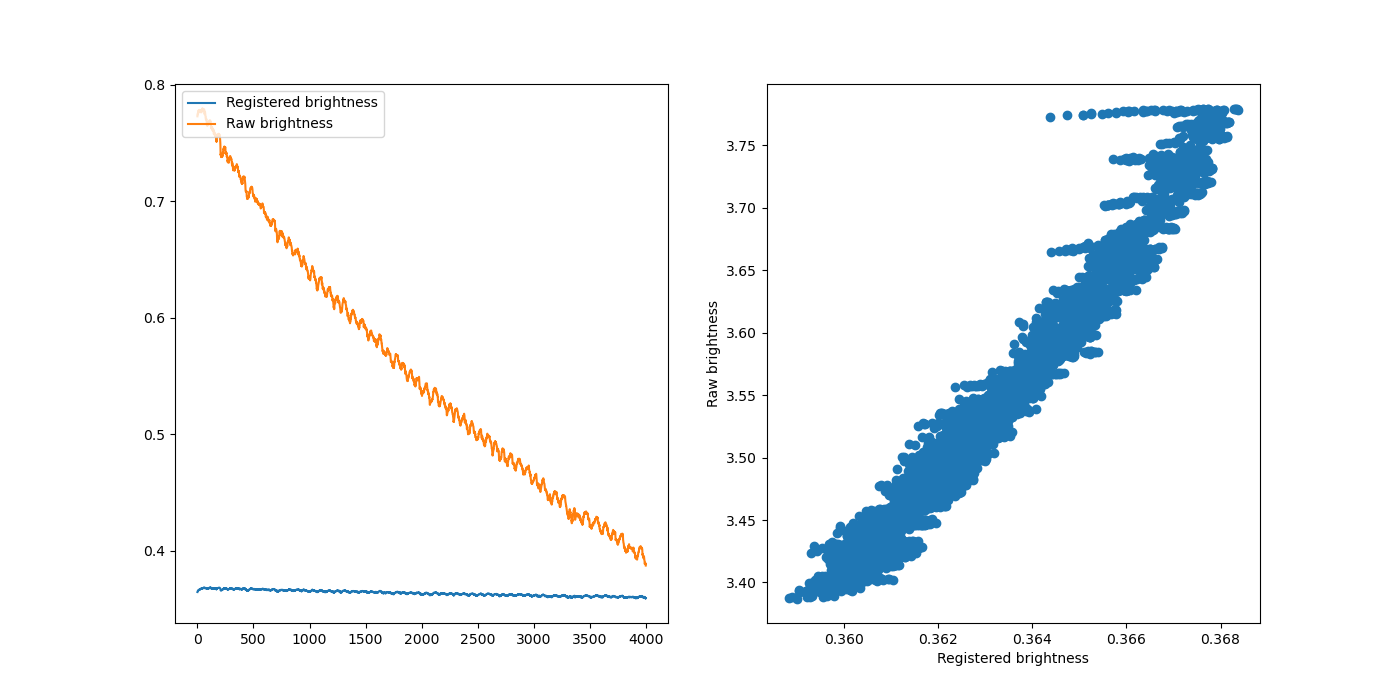

In [108]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
ax[0].plot(reg_brightness[:4000], label='Registered brightness')
ax[0].plot(np.array(raw_brightness[:4000])-3, label='Raw brightness')
ax[0].legend(loc='upper left')
ax[1].scatter(reg_brightness[:4000], raw_brightness[:4000])
ax[1].set_xlabel('Registered brightness')
ax[1].set_ylabel('Raw brightness')

Text(0, 0.5, 'Raw %RMS')

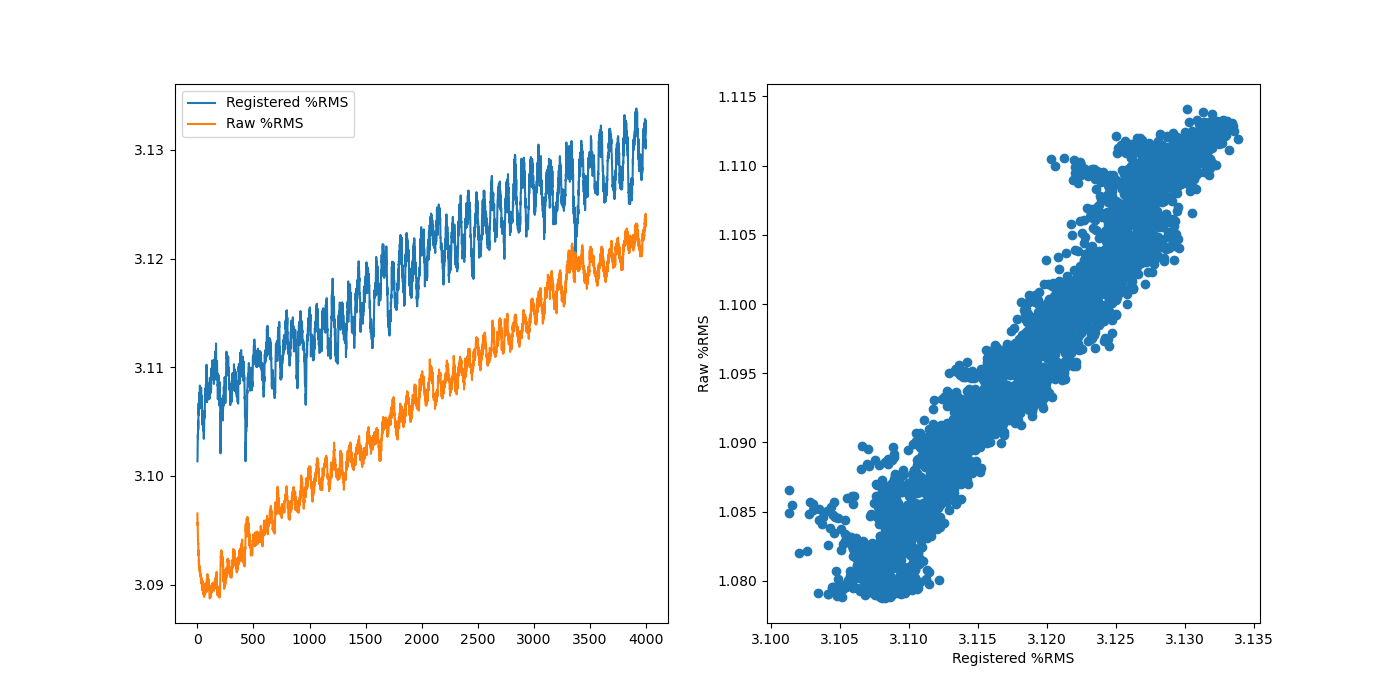

In [103]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
ax[0].plot(reg_rms, label='Registered %RMS')
ax[0].plot(np.array(raw_rms)+2.01, label='Raw %RMS')
ax[0].legend(loc='upper left')
ax[1].scatter(reg_rms, raw_rms)
ax[1].set_xlabel('Registered %RMS')
ax[1].set_ylabel('Raw %RMS')

Text(0.5, 1.0, 'r')

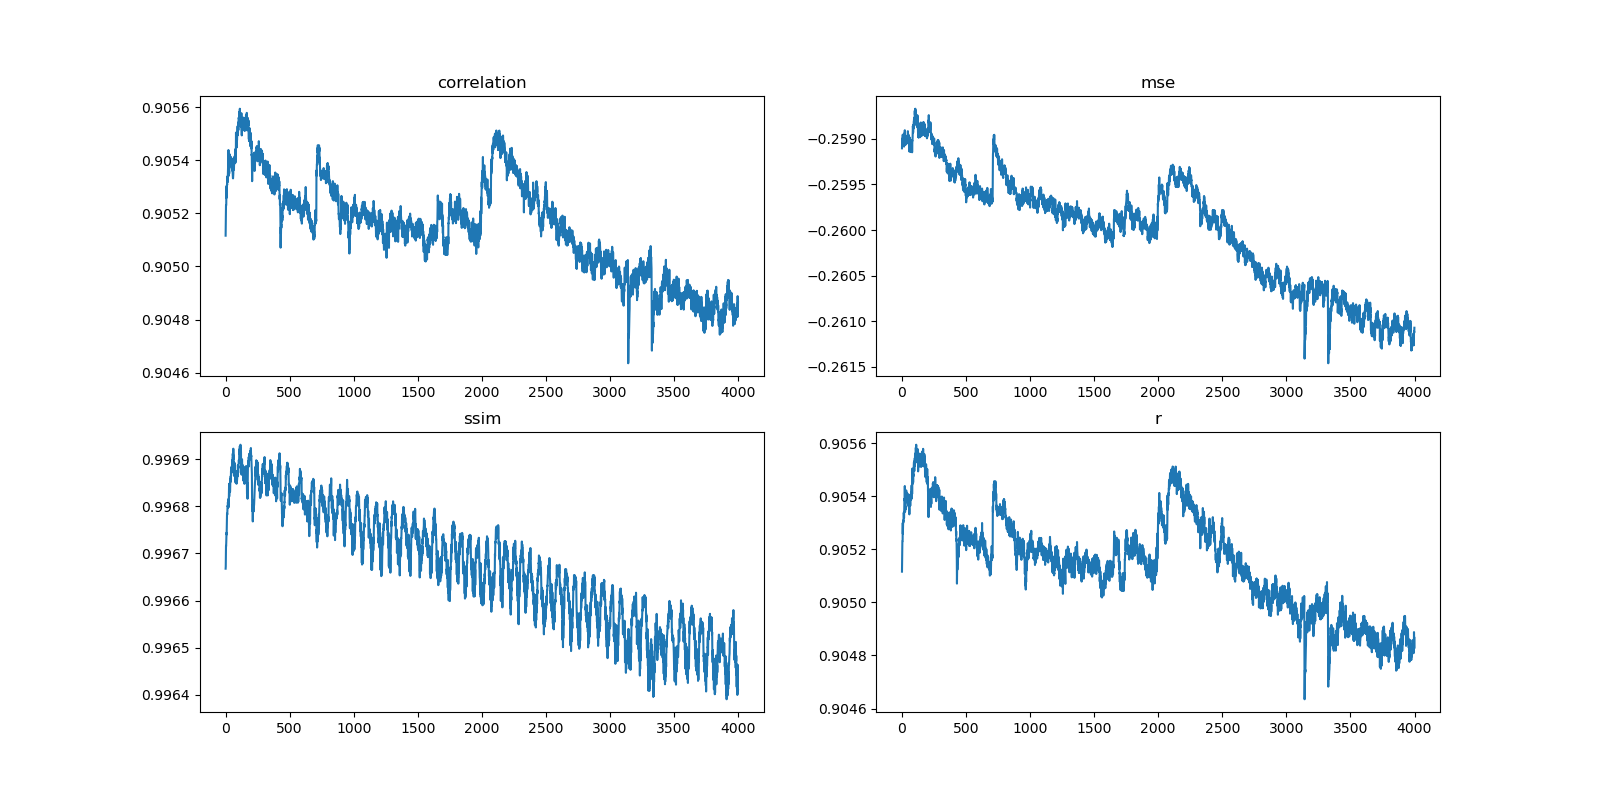

In [116]:
reg = lazyh5(paths.registered)
fig, ax = plt.subplots(2,2,figsize=(16,8))
for i in range(4):
    ax.flatten()[i].plot(reg["metrics"][:4000,i])
ax.flatten()[0].set_title("correlation")
ax.flatten()[1].set_title("mse")
ax.flatten()[2].set_title("ssim")
ax.flatten()[3].set_title("r")

In [112]:
reg["metrics"].shape

(4020, 4)